In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import optuna
import math
import time

from optuna.integration.dask import DaskStorage
import networkx as nx
from tqdm import tqdm
from scipy import io
from tqdm import tqdm
from matplotlib import pyplot as plt
from dask.distributed import Client, progress, wait
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize_scalar
from scipy import stats

import project_path
from src.util.t2m import t2m
from src.util.m2t import m2t
# from src.algos.lr_stss import lr_stss
from src.algos.lr_stss_modified import lr_stss_modified
from src.algos.lr_sts import lr_sts_hard
from src.algos.lr_sss import lr_sss_hard
from src.algos.horpca_singleton import horpca_singleton
from dask.distributed import as_completed

In [11]:
random_state = np.random.RandomState(seed=1)
##t rain data...Low rank part estimated
X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)
## test data ...Sparse part estimated
Y = np.concatenate([random_state.normal(-1, 1.5, 250),
                    random_state.normal(10,1,250),
                    random_state.normal(0, 1, 350),
                    random_state.normal(15, 0.5, 150)]).reshape(-1, 1)
truth = np.concatenate([np.zeros(250), np.ones(250),np.zeros(350),np.ones(150)])

In [2]:
def anom_detection(X,Y):
    N = np.arange(1, 11)
    models = [None for i in range(len(N))]

    print("Training Gaussian Mixture Models")
    for i in range(len(N)):
        tstart = time.perf_counter()
        models[i] = GaussianMixture(N[i]).fit(X)
        print(f"Model {i+1} trained in {time.perf_counter()-tstart:.2f} seconds")

    print("Computing AIC and BIC for each model")
    # compute the AIC and the BIC
    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]
    print("Model AICs:", AIC)
    print("Model BICs:", BIC)
    comp = np.argmin(AIC)
    M_best = models[np.argmin(AIC)]
    mu = M_best.means_
    var = M_best.covariances_
    w = M_best.weights_
    
    alt = np.zeros(len(Y))
    y_len = np.arange(0,len(Y))
    
    for j in y_len:
        y = Y[j] 
        def density_GMM(alpha):
            c = np.arange(0,comp+1)
            density = 0
            for i in c:
                cons = w[i]/(np.sqrt(2*var[i]*math.pi))
                expo= math.pow(math.e, (-1/(2*var[i]))*math.pow((y-alpha-mu[i]),2))
                density = density + (cons*expo)
            
            return(-density)
        alt[j] = -(minimize_scalar(density_GMM).fun)
    
    
    null = np.zeros(len(Y))
    c = np.arange(0,comp+1)

    for k in y_len:
        density0 = 0
        for i in c:
            cons0 = w[i]/(np.sqrt(2*var[i]*math.pi))
            expo0= math.pow(math.e, (-1/(2*var[i]))*math.pow((Y[k]-mu[i]),2))
            density0 = density0 + (cons0*expo0)
        null[k] = density0 
    
    l = -2*np.log(null/alt) ## follows chi_sq df 1
    tau = stats.chi2.ppf(0.99,1)
    
    anom = np.zeros(len(Y))
    anom[l > tau] = 1
    return(anom)

In [70]:
sum(abs(truth-anom_detection(X,Y)))/len(Y)

0.007

In [2]:
# Load pre-processed Data
cwd = os.getcwd()
data_dir = os.path.join(cwd,'..','data','nyc')

zones = gpd.read_file(os.path.join(data_dir,'taxi_zones_shapefile','taxi_zones.shp'))
zone_lookup = os.path.join(data_dir, 'taxi_zone_lookup.csv')
zone_lookup = pd.read_csv(zone_lookup)

pickups = np.load(os.path.join(data_dir,"hourly_pickup.npy"))
dropoffs = np.load(os.path.join(data_dir,"hourly_dropoff.npy"))
# # Load Emre's settings
dates = io.loadmat(os.path.join(data_dir,'dates.mat'))
regions = io.loadmat(os.path.join(data_dir,'regions.mat'))
neighbors = io.loadmat(os.path.join(data_dir,'neighbors.mat'))
regions=regions['regions'].ravel()
arrivals = io.loadmat('arrivals.mat')['Y']
# # Filter the data
# pickups = pickups[regions-1, ...]
# dropoffs = dropoffs[regions-1, ...]
zones = zones.iloc[regions-1]
# dos = np.zeros((81,53,7,24))
# dos[:,:52,:,:] = dropoffs
# dos[:,52,1:,:] = np.mean(dropoffs[:,:,1:,:],1)
# dropoffs = dos.copy()
# dos[:,:52,:,:] = pickups
# dos[:,52,1:,:] = np.mean(pickups[:,:,1:,:],1)
# pickups = dos.copy()
# del dos

dropoffs = np.moveaxis(arrivals,[0,1,2,3],[3,2,1,0])

In [3]:
pos = np.zeros((81,2))
pos[:,0] = zones.geometry.centroid.x.values
pos[:,1] = zones.geometry.centroid.y.values

position ={}
G_nyc = nx.Graph()
G_nyc.add_nodes_from([(regions[i], {'pos': pos[i,:], 'LocationID': regions[i], 'zone': zones.iloc[i]['zone']}) for i in range(81)])
edge_list =[]
for i in range(len(neighbors['neighbors'].ravel())):
    for neighbor in neighbors['neighbors'].ravel()[i].ravel():
        if np.any(np.isin(neighbor, regions)) and (neighbor!=regions[i]):
            edge_list.append((regions[i], neighbor))
    # edge_list = edge_list + [(regions[i], neighbor) for neighbor in neighbors['neighbors'].ravel()[i]]
    position[regions[i]]=pos[i,:]
G_nyc.add_edges_from(edge_list)
# G_nyc.nodes()
A = nx.adjacency_matrix(G_nyc).toarray()
Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
Dsq = np.linalg.inv(np.sqrt(Deg))
An = Dsq@A@Dsq

In [4]:
def detect_topk_events(anomaly_scores, ratio):
#     events_start_ts = pd.to_datetime(['01-Jan-2018', '03-Jan-2018 16:00:00', '14-Jan-2018 09:00:00', '20-Jan-2018 08:00:00', 
#                                     '28-Jan-2018 16:00:00', '04-Mar-2018 15:00:00', '31-Mar-2018 13:00:00', '17-Mar-2018 11:00:00',
#                                     '20-Mar-2018 10:00:00', '21-Mar-2018 16:00:00', '01-Jul-2018 17:00:00', '04-Jul-2018 17:00:00',
#                                     '25-Sep-2018 10:00:00', '04-Oct-2018 08:00:00', '04-Nov-2018 12:00:00', '09-Nov-2018 19:00:00',
#                                     '22-Nov-2018 21:00:00', '04-Dec-2018 19:00:00', '16-Dec-2018 10:00:00', '31-Dec-2018 21:00:00'
#                                     ])
    events_start_ts = pd.to_datetime(['01-Jan-2018 00:00:00', '03-Jan-2018 16:00:00', '14-Jan-2018 09:00:00', '20-Jan-2018 08:00:00', 
                                    '4-Mar-2018 15:00:00', '08-Mar-2018 18:00:00', '17-Mar-2018 11:00:00', '20-Mar-2018 10:00:00',
                                    '21-Mar-2018 16:00:00', '01-Jul-2018 17:00:00', '04-Jul-2018 17:00:00', '25-Sep-2018 10:00:00',
                                    '04-Oct-2018 08:00:00', '04-Nov-2018 12:00:00', '09-Nov-2018 19:00:00', '22-Nov-2018 21:00:00',
                                    '4-Dec-2018 19:00:00', '16-Dec-2018 10:00:00', '28-Dec-2018 12:00:00', '31-Dec-2018 21:00:00'
    ])
#     events_end_ts = pd.to_datetime(['01-Jan-2018 02:00:00', '03-Jan-2018 22:00:00', '14-Jan-2018 17:00:00', '20-Jan-2018 15:00:00',
#                                 '28-Jan-2018 23:00:00', '04-Mar-2018 22:00:00', '31-Mar-2018 20:00:00', '17-Mar-2018 17:00:00',
#                                 '20-Mar-2018 20:00:00', '21-Mar-2018 22:00:00', '01-Jul-2018 22:00:00', '04-Jul-2018 23:00:00',
#                                 '25-Sep-2018 20:00:00', '04-Oct-2018 15:00:00', '04-Nov-2018 17:00:00', '09-Nov-2018 23:30:00',
#                                 '22-Nov-2018 23:59:00', '04-Dec-2018 23:59:00', '16-Dec-2018 15:00:00', '31-Dec-2018 23:59:00'
#     ])
    events_end_ts = pd.to_datetime(['01-Jan-2018 02:00:00', '03-Jan-2018 22:00:00', '14-Jan-2018 17:00:00', '20-Jan-2018 15:00:00',
                             '4-Mar-2018 22:00:00', '08-Mar-2018 23:59:00', '17-Mar-2018 17:00:00', '20-Mar-2018 20:00:00',
                            '21-Mar-2018 22:00:00', '01-Jul-2018 22:00:00', '04-Jul-2018 23:00:00', '25-Sep-2018 20:00:00',
                            '04-Oct-2018 15:00:00', '04-Nov-2018 17:00:00', '09-Nov-2018 23:30:00', '22-Nov-2018 23:59:00',
                            '4-Dec-2018 23:59:00', '16-Dec-2018 15:00:00', '28-Dec-2018 17:00:00', '31-Dec-2018 23:59:00'
    ])
    indd = np.flip(np.argsort(anomaly_scores, axis=None))
    ind = np.unravel_index(indd[:int(len(indd)*ratio)], anomaly_scores.shape)
    topk_event_idx = ind
    anomaly_mask = np.zeros(anomaly_scores.shape, dtype=bool)
    anomaly_mask[topk_event_idx] =1
#     num_detected_events = 0
    detected_events = np.zeros(20)

    idxs = np.arange(81)
    # w = events_start_ts.isocalendar().week
    # d = events_start_ts.day_of_week
    doy = events_start_ts.day_of_year
    w = (doy-1)//(7)
    d = (doy-1) % 7
    h_s = events_start_ts.hour
    h_e = events_end_ts.hour
    for i in range(20):
        event_mask = np.zeros(anomaly_scores.shape, dtype=bool)
        locations = dates['dates'][2].ravel()[i].ravel()
        
        for loc in locations: 
            # event_mask[idxs[regions==loc], w[i]-1, d[i], h_s[i]:h_e[i]] = 1
            # event_mask[idxs[regions==loc], w[i]-1, d[i], h_e[i]] = 1
            event_mask[idxs[regions==loc], w[i], d[i], h_s[i]:h_e[i]] = 1
            event_mask[idxs[regions==loc], w[i], d[i], h_e[i]] = 1
        if np.any(event_mask * anomaly_mask):
#             num_detected_events +=1
            detected_events[i]=1
    return detected_events#num_detected_events

In [5]:
psi =  6.330030868935934 # 12.83335528216673 # 32# final: psi = 6.330030868935934
lda_l = 52.4203154644308 # 6.386243343144918 # 56#      lda_l = 
lda_1 = 381.5726253552148 # 471.62025607182056 # 48#.
lda_t = 0.05662389826485177 # 251.84760832599633# 100 #
rho = 2.8422507662618838e-5 # 5.4622401816620816e-5 # 0.0005 #
lda_2 = 1000
time_m = 4
local_m = 1
maxit = 150
psi_dist = np.array([0.83768957, 1.        , 0.36744661, 0.64250066])
res_stss = lr_stss_modified(dropoffs, An, time_m,local_m, verbose=1, max_it=maxit,
        lda2=lda_2, lda1=lda_1, lda_t=lda_t,
        lda_loc=lda_l, psis=psi_dist*psi, rho=rho, rho_upd=1.2)
abs_s = np.abs(res_stss['S'])
ratios = np.array([0.014, 0.07, 0.14, 0.3, 0.7, 1, 2, 3])/100
num_detected_events = np.array([sum(detect_topk_events(abs_s, r)) for r in ratios])
detected_events = detect_topk_events(abs_s,0.03)
print(f"Detected 3% events:\t {detected_events}")
print(f"Number of detected events:\t {num_detected_events}")
# io.savemat('nyc_taxi_lrstss_1.mat', {'S':np.moveaxis(res_stss['S'],[0,1,2,3],[3,2,1,0])})

It-2:	## |r|=103515.93550 	 ## |s|=512933.41201 	 ## rho=0.0000 obj=2772001.2452 	 ## del_obj = 2441824.9707 
It-3:	## |r|=86024.95507 	 ## |s|=82028.24821 	 ## rho=0.0000 obj=3194511.7546 	 ## del_obj = 422510.5094 
It-4:	## |r|=76924.19091 	 ## |s|=34644.39591 	 ## rho=0.0000 obj=3317128.8125 	 ## del_obj = 122617.0579 
It-5:	## |r|=67919.20059 	 ## |s|=33463.35907 	 ## rho=0.0000 obj=3475098.2214 	 ## del_obj = 157969.4089 
It-6:	## |r|=61551.51709 	 ## |s|=32141.34092 	 ## rho=0.0000 obj=3632757.6537 	 ## del_obj = 157659.4324 
It-7:	## |r|=54408.37709 	 ## |s|=28344.60347 	 ## rho=0.0000 obj=3760573.4224 	 ## del_obj = 127815.7687 
It-8:	## |r|=51302.67958 	 ## |s|=20984.79314 	 ## rho=0.0000 obj=3857522.9356 	 ## del_obj = 96949.5132 
It-9:	## |r|=44904.83616 	 ## |s|=27150.61203 	 ## rho=0.0000 obj=3992771.9055 	 ## del_obj = 135248.9699 
It-10:	## |r|=44153.87751 	 ## |s|=8378.65866 	 ## rho=0.0000 obj=4031297.7796 	 ## del_obj = 38525.8741 
It-11:	## |r|=43232.92332 	 ## |s|=7

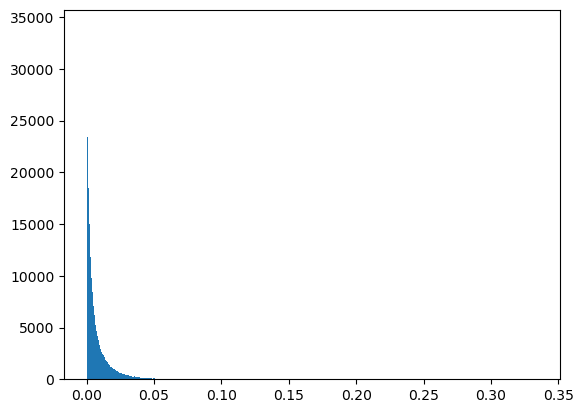

In [41]:
plt.hist(abs_s.ravel(), bins='auto')
plt.show()

In [15]:
def detect_events(anomaly_mask):
    events_start_ts = pd.to_datetime(['01-Jan-2018 00:00:00', '03-Jan-2018 16:00:00', '14-Jan-2018 09:00:00', '20-Jan-2018 08:00:00', 
                                    '4-Mar-2018 15:00:00', '08-Mar-2018 18:00:00', '17-Mar-2018 11:00:00', '20-Mar-2018 10:00:00',
                                    '21-Mar-2018 16:00:00', '01-Jul-2018 17:00:00', '04-Jul-2018 17:00:00', '25-Sep-2018 10:00:00',
                                    '04-Oct-2018 08:00:00', '04-Nov-2018 12:00:00', '09-Nov-2018 19:00:00', '22-Nov-2018 21:00:00',
                                    '4-Dec-2018 19:00:00', '16-Dec-2018 10:00:00', '28-Dec-2018 12:00:00', '31-Dec-2018 21:00:00'
    ])
    events_end_ts = pd.to_datetime(['01-Jan-2018 02:00:00', '03-Jan-2018 22:00:00', '14-Jan-2018 17:00:00', '20-Jan-2018 15:00:00',
                             '4-Mar-2018 22:00:00', '08-Mar-2018 23:59:00', '17-Mar-2018 17:00:00', '20-Mar-2018 20:00:00',
                            '21-Mar-2018 22:00:00', '01-Jul-2018 22:00:00', '04-Jul-2018 23:00:00', '25-Sep-2018 20:00:00',
                            '04-Oct-2018 15:00:00', '04-Nov-2018 17:00:00', '09-Nov-2018 23:30:00', '22-Nov-2018 23:59:00',
                            '4-Dec-2018 23:59:00', '16-Dec-2018 15:00:00', '28-Dec-2018 17:00:00', '31-Dec-2018 23:59:00'
    ])
    # indd = np.flip(np.argsort(anomaly_scores, axis=None))
    # ind = np.unravel_index(indd[:int(len(indd)*ratio)], anomaly_scores.shape)
    # topk_event_idx = ind
    # anomaly_mask = np.zeros(anomaly_scores.shape, dtype=bool)
    # anomaly_mask[topk_event_idx] =1
#     num_detected_events = 0
    detected_events = np.zeros(20)

    idxs = np.arange(81)
    # w = events_start_ts.isocalendar().week
    # d = events_start_ts.day_of_week
    doy = events_start_ts.day_of_year
    w = (doy-1)//(7)
    d = (doy-1) % 7
    h_s = events_start_ts.hour
    h_e = events_end_ts.hour
    for i in range(20):
        event_mask = np.zeros(anomaly_mask.shape, dtype=bool)
        locations = dates['dates'][2].ravel()[i].ravel()
        
        for loc in locations: 
            # event_mask[idxs[regions==loc], w[i]-1, d[i], h_s[i]:h_e[i]] = 1
            # event_mask[idxs[regions==loc], w[i]-1, d[i], h_e[i]] = 1
            event_mask[idxs[regions==loc], w[i], d[i], h_s[i]:h_e[i]] = 1
            event_mask[idxs[regions==loc], w[i], d[i], h_e[i]] = 1
        if np.any(event_mask * anomaly_mask):
#             num_detected_events +=1
            detected_events[i]=1
    return detected_events#num_detected_events

In [7]:
Y = abs_s.ravel().reshape(-1, 1)
X = res_stss['X'].ravel().reshape(-1, 1)


N = np.arange(1, 11)
models = [None for i in range(len(N))]
print("Training Gaussian Mixture Models")
for i in range(len(N)):
    tstart = time.perf_counter()
    models[i] = GaussianMixture(N[i]).fit(X)
    print(f"Model {i+1} trained in {time.perf_counter()-tstart:.2f} seconds")

print("Computing AIC and BIC for each model")
# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
print("Model AICs:", AIC)
print("Model BICs:", BIC)
comp = np.argmin(AIC)
print("Model with best AIC:",comp+1)
M_best = models[np.argmin(AIC)]
mu = M_best.means_
var = M_best.covariances_
w = M_best.weights_




Training Gaussian Mixture Models
Model 1 trained in 0.44 seconds
Model 2 trained in 2.72 seconds
Model 3 trained in 3.31 seconds
Model 4 trained in 4.50 seconds
Model 5 trained in 15.35 seconds
Model 6 trained in 13.68 seconds
Model 7 trained in 11.98 seconds
Model 8 trained in 14.54 seconds
Model 9 trained in 13.76 seconds
Model 10 trained in 10.88 seconds
Computing AIC and BIC for each model
Model AICs: [9432011.920647148, 8591329.253198052, 8476575.05884919, 8444629.102297373, 8333870.745479434, 8327826.813131616, 8319651.946740253, 8318442.414337817, 8315793.357909061, 8311006.551210753]
Model BICs: [9432034.898057243, 8591386.69672329, 8476666.96848957, 8444755.478052897, 8334031.5873501, 8328022.121117426, 8319881.720841206, 8318706.654553912, 8316092.064240299, 8311339.723657134]


In [13]:
# alt = np.zeros(len(Y))
# y_len = np.arange(0,len(Y))
# tstart = time.perf_counter()
# for j in tqdm(y_len):
#     y = Y[j]

#     def density_GMM(alpha):
#         c = np.arange(0,comp+1)
#         density = 0
#         for i in c:
#             cons = w[i]/(np.sqrt(2*var[i]*math.pi))
#             expo= math.pow(math.e, (-1/(2*var[i]))*math.pow((y-alpha-mu[i]),2))
#             density = density + (cons*expo)
        
#         return(-density)
        
#     alt[j] = -(minimize_scalar(density_GMM).fun)

# null = np.zeros(len(Y))
# c = np.arange(0,comp+1)

# for k in tqdm(y_len):
#     density0 = 0
#     for i in c:
#         cons0 = w[i]/(np.sqrt(2*var[i]*math.pi))
#         expo0= math.pow(math.e, (-1/(2*var[i]))*math.pow((Y[k]-mu[i]),2))
#         density0 = density0 + (cons0*expo0)
#     null[k] = density0
# print(f"Done in {time.perf_counter()} seconds")


In [69]:
# labels = anom_detection(x,s).reshape(abs_s.shape)
l = -2*np.log(null/alt) ## follows chi_sq df 1
tau = stats.chi2.ppf(0.80431,1)
anom = np.zeros(len(Y))
anom[l > tau] = 1
detected_events = detect_events(anom.reshape(abs_s.shape))
print(f"Detected events:\t {detected_events}")
print(f"Number of detected events:\t {sum(detected_events)}")
# sum(abs(truth-anom_detection(X,Y)))/len(Y)

Detected events:	 [0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
Number of detected events:	 10.0


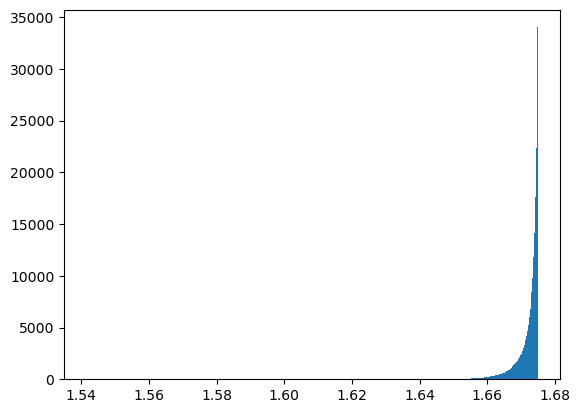

In [40]:
x, bin_edges = np.histogram(l,50)
plt.hist(l, bins='auto')
plt.show()

In [ ]:
## Control Variables
gt = 'grid'
graph_param = (8,5)
dtn = 1
rad =0
amp =1
window = 'boxcar'
distribution = 'bernoulli'
local_distribution = 'constant'
dims = (40,24,7,20)
ranks = (8,8,5,5)
NoG = 1
NoT = 10
time_m = 2
local_m = 1
lda_2 = 1000
psi = 23.467775089144254 # 20
maxit = 200
maxit_horpca = 200